# Determining Student Knowledge Status

### Introduction

Understanding how student study methods and examination results affect the retention of information is essential to create better teaching and learning methodologies. At a university in Turkey, Ph.D students collected data on undergraduate students' understanding of Electrical DC Machines. They utilized five normalized characteristics to determine the knowledge level of students from very low to high. The five variables included the amount of study time, number of repetitions and exam performance for goal object materials as well as the amount of study time and exam performance for related objects with the goal object.

Through this project, we propose to answer the following question: 

> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

We aim to achieve this by training a model that, given the five aforementioned characteristics, will classify the knowledge level of a student. 

### Preliminary Exploratory Data Analysis

In [55]:
## Run this cell before continuing
library(repr)
library(readxl)
library(cowplot)
library(recipes)
library(yardstick)
library(tidyverse)
library(tidymodels)

options(repr.matrix.max.rows = 6)

The dataset we will be using is the **User Knowledge Modeling Data Set** provided by the *UCI Machine Learning Repository*, linked [here](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

This dataset has the following variables:
- `STG`: The degree of study time for goal object materials
- `SCG`: The degree of repetition number of user for goal object materials
- `STR`: The degree of study time of user for related objects with goal object
- `LPR`: The exam performance of user for related objects with goal object
- `PEG`: The exam performance of user for goal objects
- `UNS`: The knowledge level of user

Utilizing the first five variables, we aim to predict the sixth variable, `UNS`, which is a student's knowledge level. The knowledge level variable has one of four possible labels: `High`, `Middle`, `Low` and `Very Low`.

Before doing any analysis, we first need to obtain our training and testing data and separate the two in order to avoid overfitting and foster generalizability. The dataset is already split into training and testing data, so we do not have to perform an initial split to separate the data. Now, let's read in our training and testing data:

In [56]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"
download.file(url, destfile = "data/Data_User_Modeling_Dataset.xls")

In [57]:
knowledge_training <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 2) %>%
    select(STG:UNS)

knowledge_training

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [58]:
knowledge_testing <- read_excel("data/Data_User_Modeling_Dataset.xls", sheet = 3) %>%
    select(STG:UNS)

knowledge_testing

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


Note that the first five variables are already normalized to be in the range [0, 1], where a higher number is associated with a higher degree of preparation or a higher exam performance. This will actually make things easier for us when training our classification model because we won't have to scale or center the variables!

Additionaly, note that out of all category names, only `STG` and `STR` properly communicate what they represent. Let's change the variable names to the following, which better communicate what they represent:
- `STG`: Study Time degree for Goal object materials
- `RNG`: Repetition Number degree for Goal object materials
- `STR`: Study Time degree for Related objects with goal object materials
- `EPR`: Exam Performance for Related objects with goal objects
- `EPG`: Exam Performance for Goal object
- `SKL`: Student Knowledge Level

In [59]:
knowledge_testing <- knowledge_testing %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)

knowledge_training <- knowledge_training %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)

head(knowledge_training, n = 2)
head(knowledge_testing, n = 2)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.0,0.00,0.0,very_low
0.08,0.08,0.1,0.24,0.9,High


STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low


That's better. Let's continue tidying up the data! 

As we can see from the above dataframes, the labelling done on the test and training sets are different! In particular, the label representing a very low knowledge level varies. In the training dataset it's 'very_low' and in the test dataset it's 'Very Low'.

This may not be the only difference, so let's compare the labels present in both the test and training datasets.

In [60]:
knowledge_training %>%
    pull(SKL) %>%
    unique()

[1] "very_low" "High"     "Low"      "Middle"

In [61]:
knowledge_testing %>%
    pull(SKL) %>%
    unique()

[1] "Very Low" "Low"      "High"     "Middle"

As we can see, the only differences between the two sets of labels are the order and the spacing for the very low category of knowlege. A few changes will fix this right up and make the data easier to work with:
- Firstly, we will remove the underscore in the label 'very_low' in the training dataset
- Secondly, we will transform all knowledge level (SKL) labels to lower case
- Then we'll transform the knowledge level (SKL) column to be a factor column (instead of the current character column)
- And, finally, we'll order the different levels to be in ascending order

In [62]:
# remove the underscore
knowledge_training <- knowledge_training %>%
    mutate(SKL = replace(knowledge_training$SKL, knowledge_training$SKL == "very_low", "very low"))

# change label to a factor
knowledge_training <- knowledge_training %>%
    mutate(SKL = as_factor(tolower(SKL)))

knowledge_training$SKL <- factor(knowledge_training$SKL, levels=c("very low", "low", "middle", "high"))

knowledge_training %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "middle"   "high"

And for the testing dataset:

In [63]:
knowledge_testing <- knowledge_testing %>%
    mutate(SKL = as_factor(tolower(SKL)))

knowledge_testing$SKL <- factor(knowledge_testing$SKL, levels=c("very low", "low", "middle", "high"))

knowledge_testing %>%
    pull(SKL) %>%
    levels()

[1] "very low" "low"      "middle"   "high"

Perfect! Now our class labels are consistent across datasets and from the tables above we know our data is tidy, that is: 
- each row is a single observation (a student)
- each column is a single variable, and 
- each cell contains a single value (normalized degree of study or exam performance)

Now that we have properly wrangled the data, we can proceed to do the following:
1. lock our test data in an imaginary box, only to be opened when evaluating the model we will build
2. summarize our training data 
3. explore and visualize patterns or trends within the data
4. build our model and, finally
5. evaluate the model on our test dataset.

First things first, let's summarize the training data to gain some more insight. To do this, we create a table that will do the following for each knowledge level:
1. report the number of observations
2. report the predictor means, and 
3. report the number of rows that have missing data

In [64]:
summary_table <- knowledge_training %>%
    group_by(SKL) %>%
    summarize(class_count = n(),
              mean_stg = mean(STG),
              mean_rng = mean(RNG),
              mean_str = mean(STR),
              mean_epr = mean(EPR),
              mean_epg = mean(EPG),
              missing_rows = sum(is.na(SKL))) %>%
    arrange(mean_epg)
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



SKL,class_count,mean_stg,mean_rng,mean_str,mean_epr,mean_epg,missing_rows
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
very low,24,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333,0
low,83,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651,0
middle,88,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636,0
high,63,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968,0


It appears that our target variable contains no missing values! 

On the other hand, under the `class_count` variable, we notice that the class `very_low` contains significantly less observations than other classes - this can potentially affect the accuracy of the model when predicting this class - as it wouldn't have been as well trained. Potential solutions to this problem include $upsampling$ the minority class (`very_low`) however, the context of our problem suggests that this may not be an ideal path to take. When dealing with an academic dataset, it's likely that most students will be positioned centrally around the `low`, `middle` and `high` levels, and fewer will be on the extremes of `very low` or `very high` (if there was a `very high` class). Therefore, we will not be upsampling this minority class.

Next up, if we look at some of the different predictor means in relation to the student's knowledge level, we see that as the predictor mean increases, the student's knowledge level increases as well (with the exception of `EPR` and `STR`). Could this be a significant trend? Let's visualize the different predictor - student knowlege level relationships to get a better understanding.

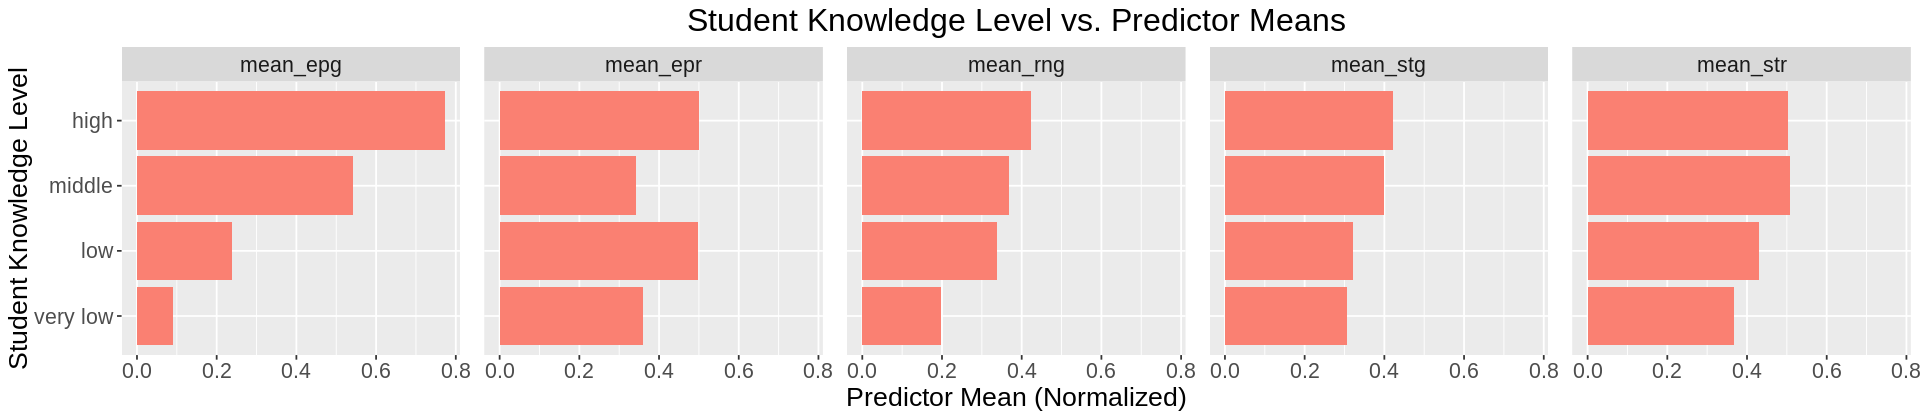

In [65]:
options(repr.plot.width = 16, repr.plot.height = 3.5)

summary_long <- summary_table %>%
    select(-class_count, -missing_rows)%>%
    pivot_longer(cols = mean_stg:mean_epg,
                 names_to = "predictor_name",
                 values_to = "mean")

training_plot <- summary_long %>%
    ggplot(aes(x = reorder(SKL, mean), y = mean)) + 
    geom_bar(stat='identity', fill="salmon") + 
    facet_wrap(~predictor_name, nrow = 1) + 
    ggtitle("Student Knowledge Level vs. Predictor Means") +
    xlab("Student Knowledge Level") + 
    ylab("Predictor Mean (Normalized)") + 
    theme(text = element_text(size = 16),
          panel.spacing = unit(1, "lines"),
          plot.title = element_text(hjust = 0.5)) + 
    coord_flip()

training_plot

From the above plot, we note that there is a positive relationship between a student's knowledge level, `SKL`, and the following predictors: `STG`, `RNG` and `EPG`. To further visualize this relationship, let's create a scatterplot. 

To visualize this data, we will plot the mean of the preparation variables (`STG`, `RNG`, and `STR`) on the x-axis and the mean of the examination variables (`EPG` and `EPR`) on the y-axis, since it follows that exam performance is influenced by student preparation. To visualize the distribution of student knowledge levels with respect to preparation and examination results, we will color each point on our scatterplot according to the student knowledge level.

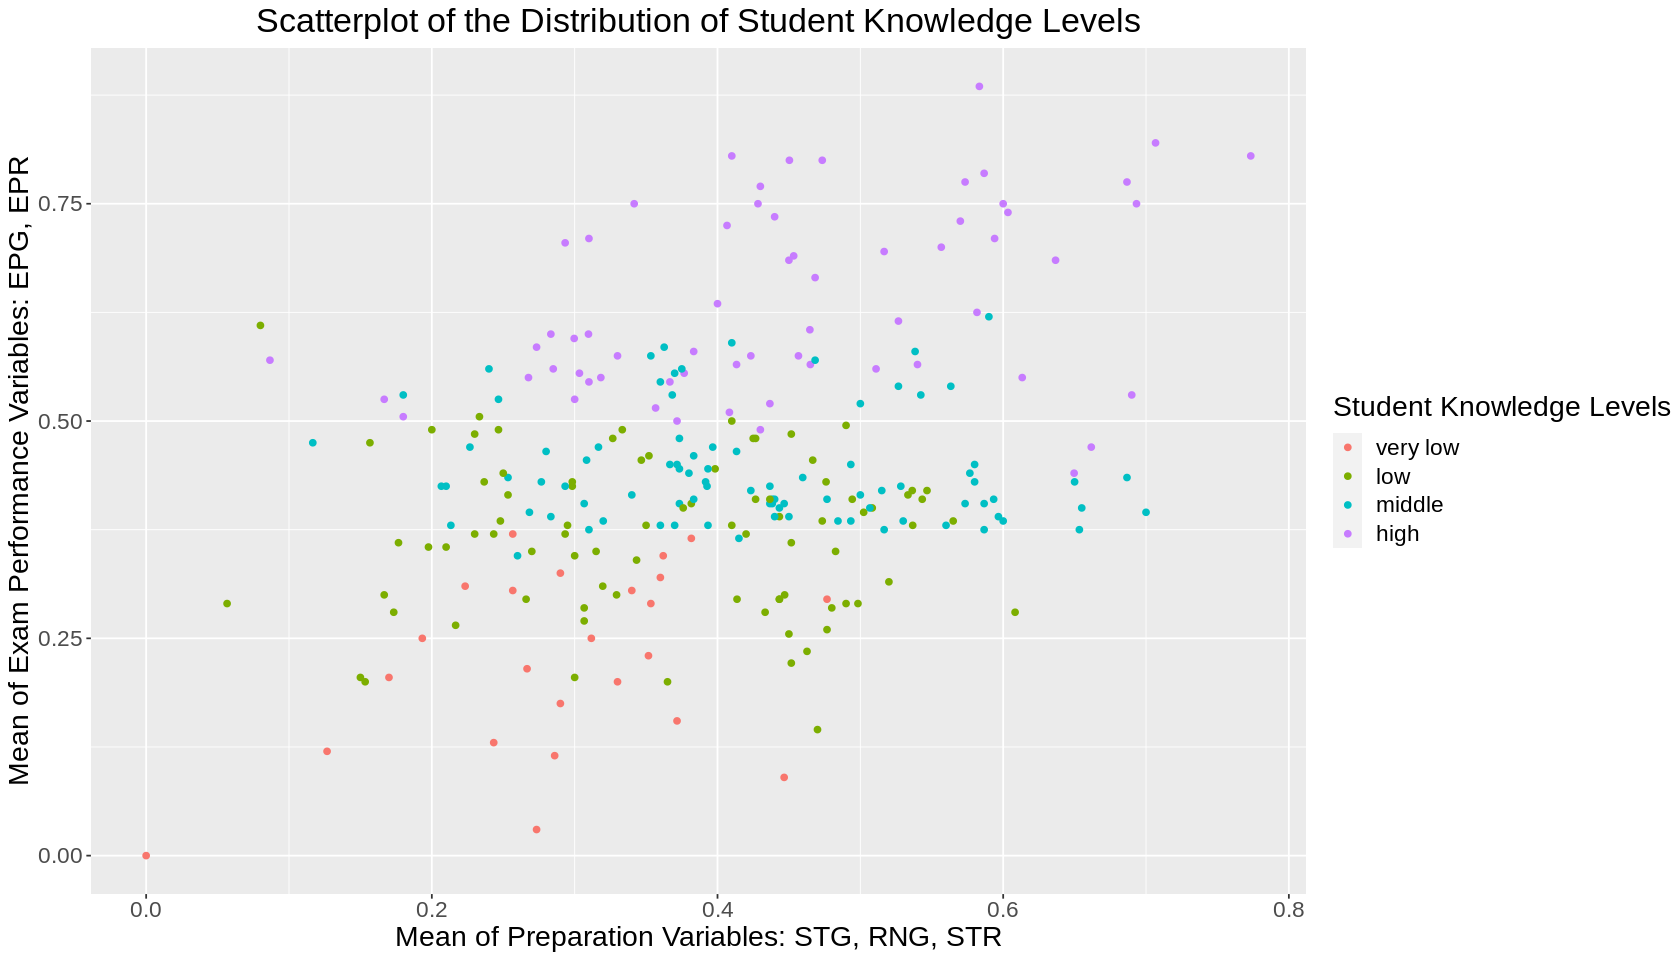

In [66]:
# Adding prep and exam columns to our dataset for visualization
knowledge_viz <- knowledge_training %>%
    mutate(prep = (STG + RNG + STR) / 3, exam = (EPG + EPR) / 2) %>%
    select(SKL, prep, exam)

# Displaying our plot
options(repr.plot.width = 14, repr.plot.height = 8)
knowledge_viz %>%
    ggplot(aes(x=prep, y=exam, color=SKL)) +
    geom_point() + theme(text = element_text(size = 16)) +
    labs(title="Scatterplot of the Distribution of Student Knowledge Levels", 
         x="Mean of Preparation Variables: STG, RNG, STR",
         y="Mean of Exam Performance Variables: EPG, EPR",
         color="Student Knowledge Levels") + 
    theme(text = element_text(size = 17),
          plot.title = element_text(hjust = 0.5))

This visualization shows the variation of student knowledge levels: 'very low' observations are toward the bottom left of the graph; 'low' observations are found towards the bottom center of the graph; 'middle' observations are located a bit higher than these, still at the center; lastly, 'high' observations are seen at the top right of our graph. This indicates that as predictor variables increase, our student knowledge level increases as well. 

From our above plots, we can hypothesize that higher degrees of preparation and exam results are associated with higher levels of student knowledge, and can expect a well trained model to recognize and predict along this trend.

### Model Creation

We begin by selecting the type of model we will be building. Seeing as we aim to classify a student's knowledge level into one of four categories, our problem is one of classification by nature, and therefore, we will use the K-Nearest Neighbors algorithm.

According to Deng et al (2015), this algorithm “selects $k$ nearest training samples for a test sample, and then predicts the test sample with the major class among $k$ nearest training samples.” For example, if we choose the number 3, then we take the 3 nearest observations and use majority of their classes to dictate the class of the observation we are currently handling.

To build our model, we will first find the number of neighbors, $k$, that results in the highest accuracy.

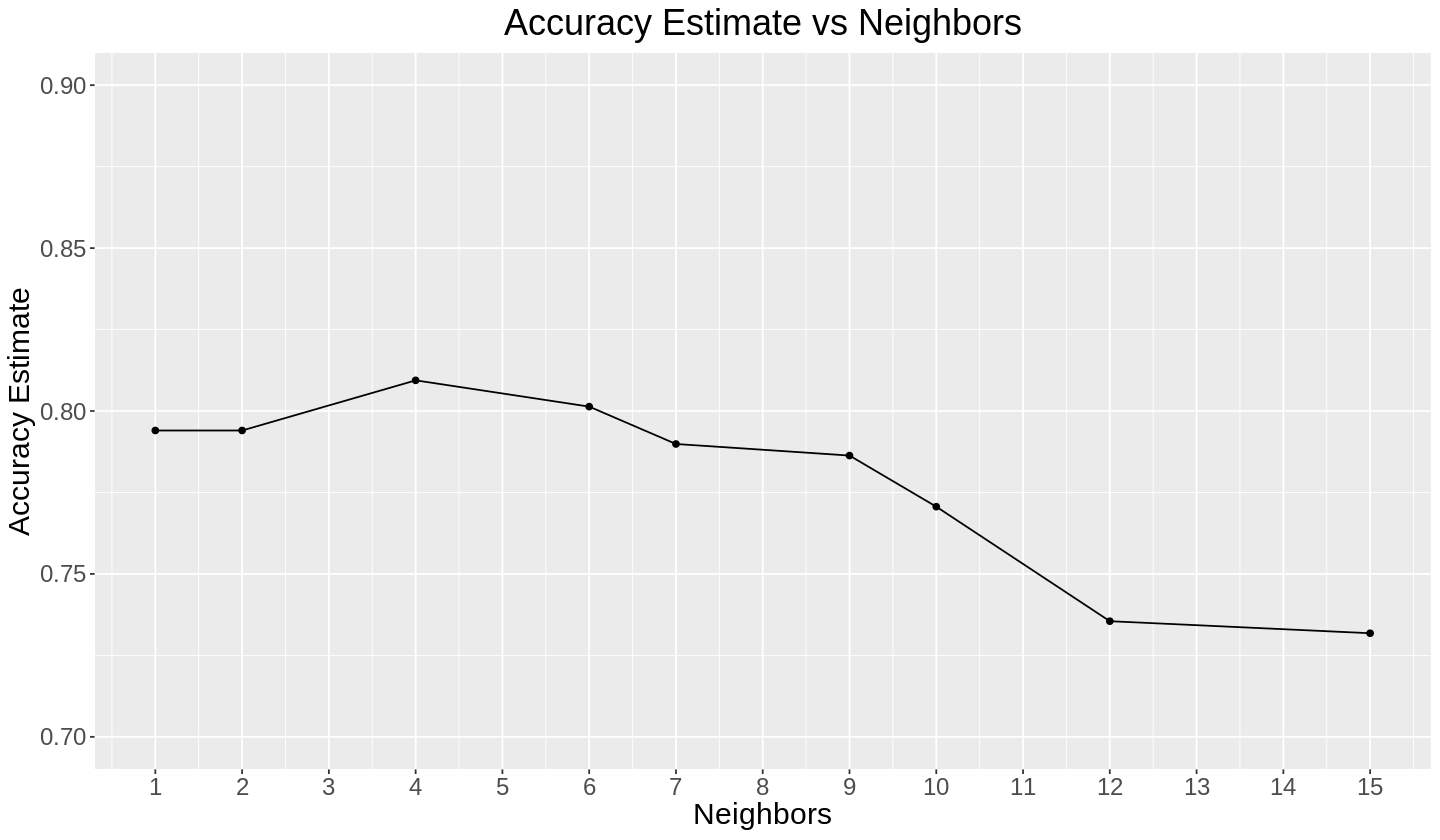

In [67]:
options(repr.plot.width = 12, repr.plot.height = 7)
set.seed(18)

# Create the knn recipe 
knn_recipe <- recipe(SKL ~ STG + RNG + STR + EPR + EPG, data = knowledge_training)

# Create the knn spec to find the best k-value 
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create the v-fold 
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = SKL)

# Create the workflow and collect statistics
knn_results <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = knowledge_vfold, grid = 10) %>%
    collect_metrics()

# Calculate and plot accuracy estimates
accuracies <- knn_results %>%
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    ggtitle("Accuracy Estimate vs Neighbors") +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +
    scale_y_continuous(limits = c(0.7, 0.9)) +
    theme(text = element_text(size = 18),
          plot.title = element_text(hjust = 0.5))
accuracy_versus_k

From the plot above, $k = 4$ would yield the highest accuracy, and choosing values close to $k = 4$ will not significantly decrease our accuracy.

Using this $k$, we can create our final model and evaluate it on our test dataset to determine its accuracy.

In [69]:
set.seed(2022)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow() %>%
    add_recipe(knn_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = knowledge_training)

knowledge_predictions <- knn_fit %>%
    predict(knowledge_testing) %>%
    bind_cols(knowledge_testing)

head(knowledge_predictions, n = 5)

.pred_class,STG,RNG,STR,EPR,EPG,SKL
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
very low,0.00,0.10,0.50,0.26,0.05,very low
low,0.05,0.05,0.55,0.60,0.14,low
high,0.08,0.18,0.63,0.60,0.85,high
high,0.20,0.20,0.68,0.67,0.85,high
high,0.22,0.22,0.90,0.30,0.90,high


Under the `.pred_class` column, we find the predictions made by our classification model and under the `SKL` column, we find the true values of the observations. To evaluate the accuracy of our model, we collect metrics - specifically the $accuracy$ metric:

In [70]:
knowledge_metrics <- knowledge_predictions %>%
    metrics(truth = SKL, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

knowledge_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8275862


The accuracy of our model as evaluated on the testing dataset is around 83%. Is this good? Let's have a look at a confusion matrix before we answer this:

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



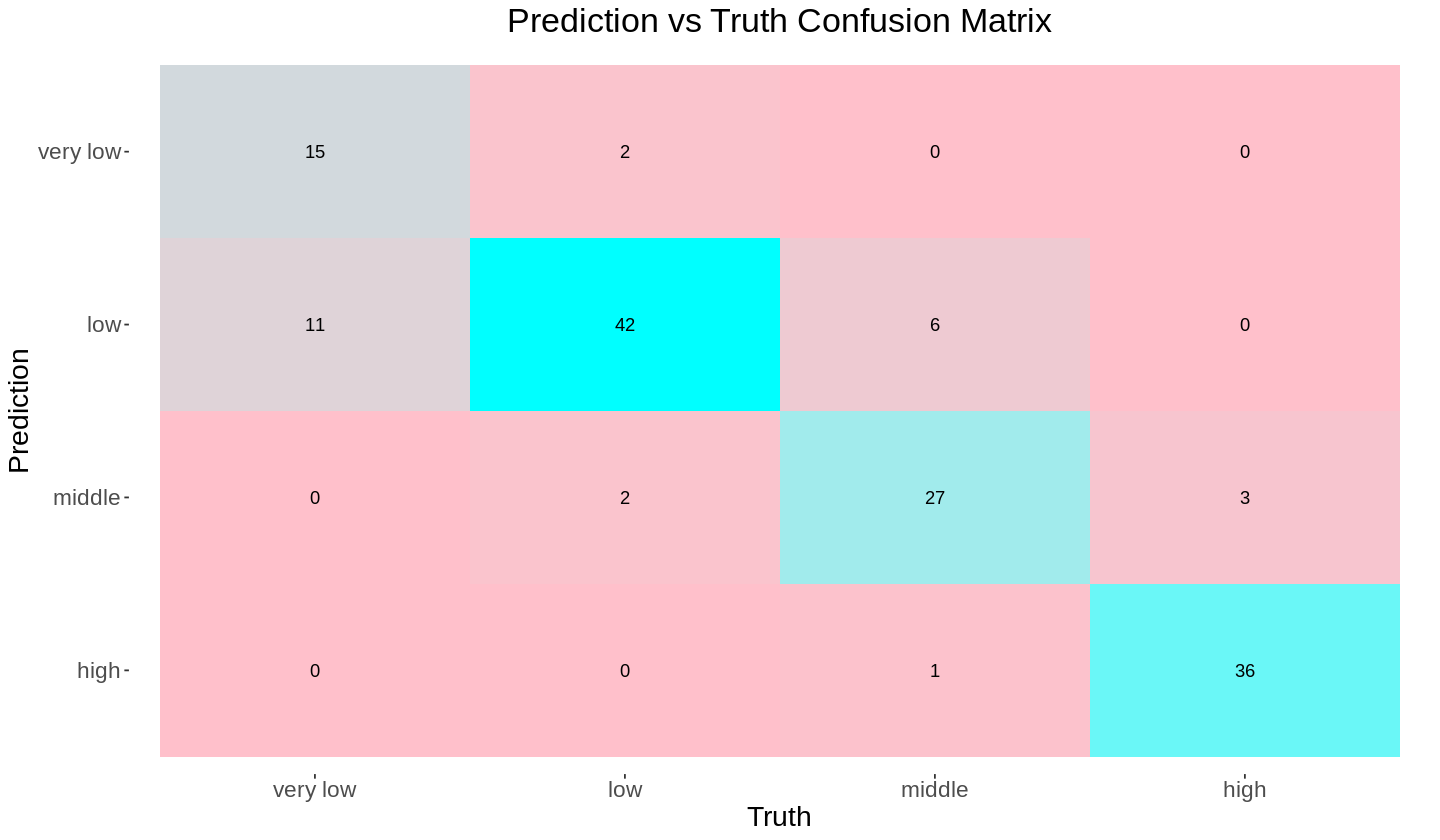

In [71]:
knowledge_predictions %>%
    conf_mat(truth = SKL, estimate = .pred_class) %>%
    autoplot(type = "heatmap") +
    scale_fill_gradient(low = "pink", high = "cyan") +
    ggtitle("Prediction vs Truth Confusion Matrix") + 
    theme(text = element_text(size = 17),
          plot.title = element_text(hjust = 0.5))

The confusion matrix above, firstly, confirms our thoughts about the model's accuracy when predicting the `very low` category of student knowledge. We hypothesized that the model may not perform as well when predicting for this class given the few observations available for training, and that is true. For this class alone, the model has a prediction accuracy of $15$ / $26$ or $57$%. That is very low, but expected. On the other hand, the model was very good at predicting the class labels `low`, `middle` and `high`. Excluding the `very low` class, the model made $105$ correct predictions out of $119$ total predictions - an accuracy of $88$%, which is a much better prediction accuracy.

Combined, we arrive at a total model prediction accuracy of $83$%. For this particular use case, this is a good prediction accuracy as the cost of a $false$ $negative$ or $false$ $positive$ is not significant. For example, having a student who should be classified as a `very low` knowledge retention student be classified as a `low` knowledge retention student does not cost much. Therefore, we are very happy with this model accuracy.

### Discussion

##### What We Found

The visualization below compares the trends uncovered by our data analysis and those uncovered by the model.

`summarise()` ungrouping output (override with `.groups` argument)



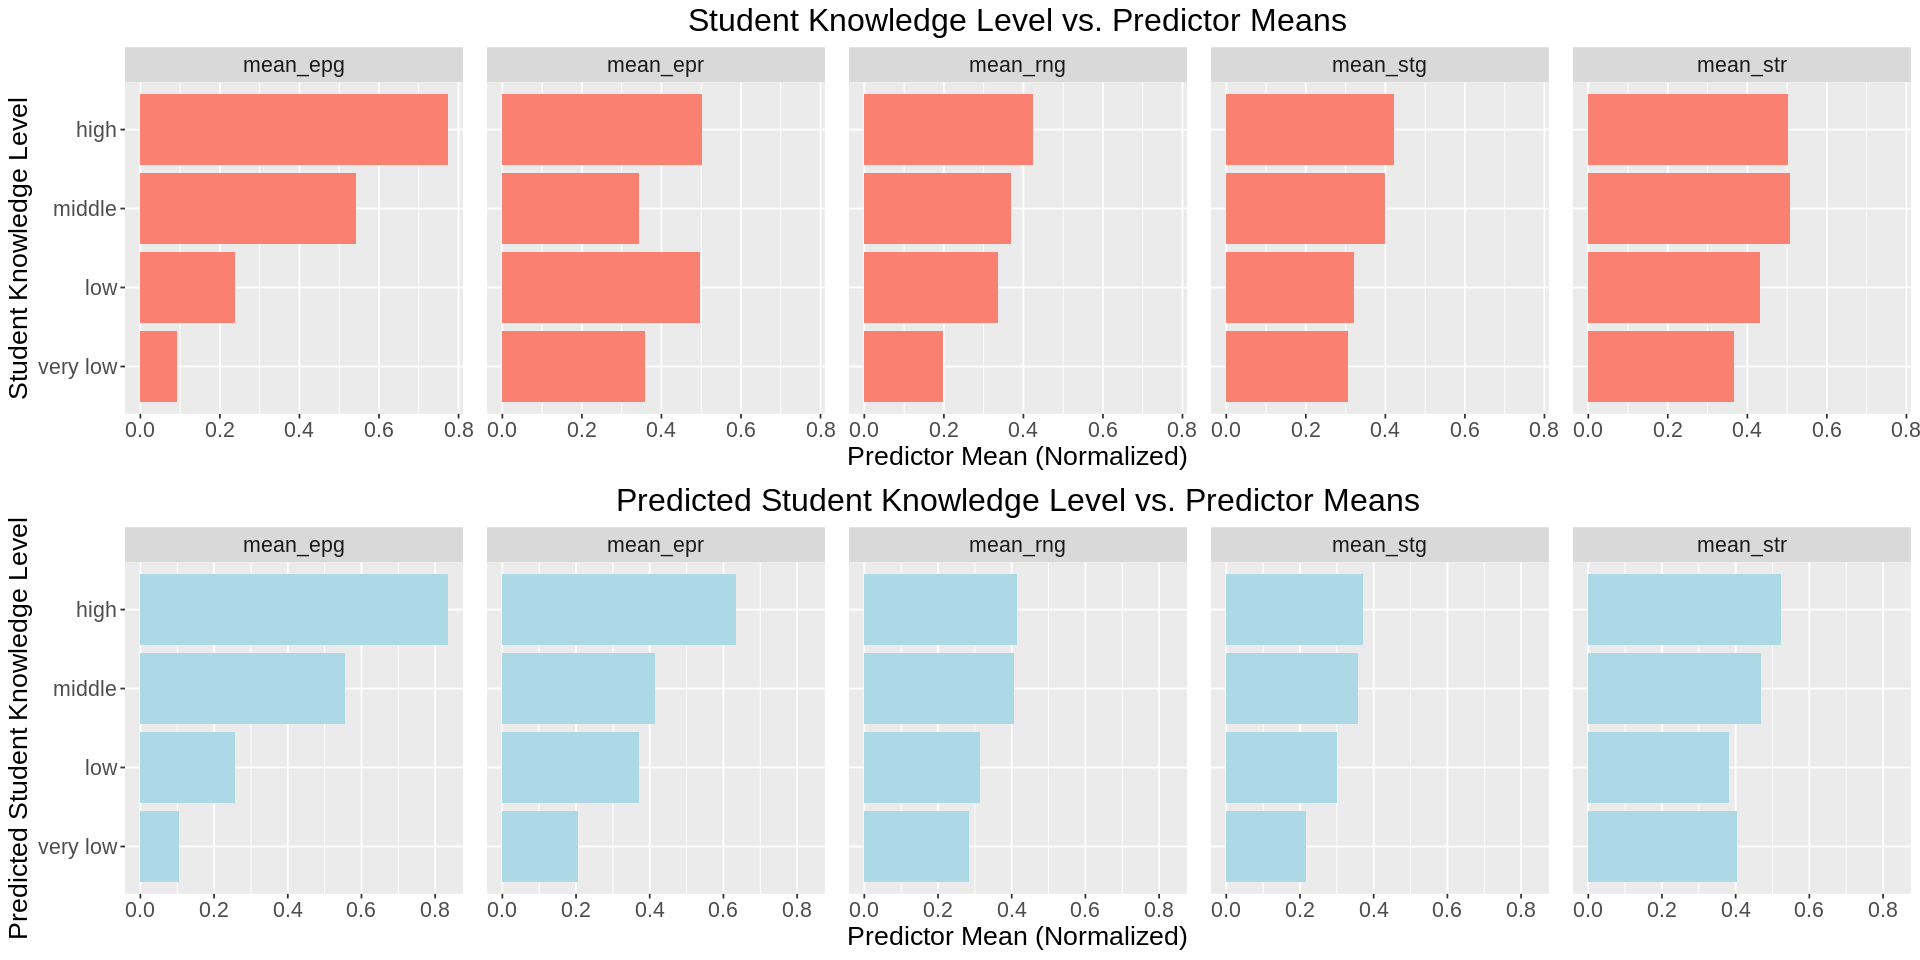

In [72]:
options(repr.plot.width = 16, repr.plot.height = 8)

prediction_summary_long <- knowledge_predictions %>%
    group_by(.pred_class) %>%
    summarize(mean_stg = mean(STG),
              mean_rng = mean(RNG),
              mean_str = mean(STR),
              mean_epr = mean(EPR),
              mean_epg = mean(EPG)) %>%
    pivot_longer(cols = mean_stg:mean_epg,
                 names_to = "predictor_name",
                 values_to = "mean")

prediction_plot <- prediction_summary_long %>%
    ggplot(aes(x = reorder(.pred_class, mean), y = mean)) + 
    geom_bar(stat='identity', fill="lightblue") + 
    facet_wrap(~predictor_name, nrow = 1) + 
    ggtitle("Predicted Student Knowledge Level vs. Predictor Means") +
    xlab("Predicted Student Knowledge Level") + 
    ylab("Predictor Mean (Normalized)") + 
    theme(text = element_text(size = 16),
          panel.spacing = unit(1, "lines"),
          plot.title = element_text(hjust = 0.5)) + 
    coord_flip()

plot_grid(training_plot, prediction_plot, ncol=1)

When beginning this project, we sought to answer the question:
> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

Through our data analysis we uncovered a strong association between a student's degree of preparation and examination results, and their knowledge retention level. Specifically, we uncovered a positive relationship between the two. As a student's degree of preparation and examination results increased, their knowledge retention level increased as well.

In the visualization above, we see that the model uncovered the same positive trend and predicted along those lines. Specifically, the 'Predicted Student Knowledge vs Predictor Means' visualization imitates the 'Student Knowledge vs Predictor Means' visualization - illustrating the underlying positive relationship between a student's preparation and examination results, and their knowledge retention level.

##### What We Expected To Find

These results are in-line with our expectations, as one expects a high retention level from a student who prepares and performs well. This expectation is validated by the positive association between student knowledge level and preparation and examination performance, as seen in the above visualization. Additionally, we did not expect the model to achieve an extremely high accuracy ($> 90$%), due to the lack of observations for the `very low` class - as discussed above. Indeed, the model performed as expected, struggling to differentiate between the `low` and `very low` classes.

##### Impact

There are many implications that our findings could influence. Primarily, our analysis showcases that study time and exam performance can be used to determine the knowledge level of an individual. This could be impactful in developing models to guide improvements in the educational system as stated in Kahraman et al (2010). In addition, by determining how students will retain information after completing a university course or degree, hiring committees and companies can hire candidates with high knowledge retention levels.

##### Future Questions

In the future it would be impactful to specifically investigate which of the five categories (involving study time or exam performance for goal or related objects) have the greatest influence on knowledge level. Such discoveries could better inform the academic community on the most effective approaches to developing and retaining knowledge. Finally, this analysis could additionally be performed using other algorithms, besides the K-Nearest Neighbour algorithm, to determine if the results differ or are more accurate in determining the knowledge level of an individual.

### References

* Deng, Z., Zhu, X., Cheng, D., Zong, M., & Zhang, S. (2015). Efficient kNN classification for big data. *Neurocomputing 195*. 143-148. https://doi.org/10.1016/j.neucom.2015.08.112
* Kahraman, H., Sagiroglu, S., & Colak, I. (2010). Development of adaptive and intelligent web-based educational systems. *4th International Conference on Application of Information and Communication Technologies*,1-5, doi: 10.1109/ICAICT.2010.5612054.